In [563]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)

# Connect and drop the first row of each dataFrame 

In [564]:
con = sqlite3.connect("Dataset/database.db")

awards_players_df = pd.read_sql_query("SELECT * FROM awards_players", con)
coaches_df = pd.read_sql_query("SELECT * FROM coaches", con)
players_teams_df = pd.read_sql_query("SELECT * FROM players_teams", con)
players_df = pd.read_sql_query("SELECT * FROM players", con)
series_post_df = pd.read_sql_query("SELECT * FROM series_post", con)
teams_df = pd.read_sql_query("SELECT * FROM teams", con)

awards_players_df = awards_players_df.tail(-1)
coaches_df = coaches_df.tail(-1)
players_teams_df = players_teams_df.tail(-1)
players_df = players_df.tail(-1)
series_post_df = series_post_df.tail(-1)
teams_df = teams_df.tail(-1)

Added the data used for the competition aspect of this project.

In [565]:
coaches_df_11 = pd.read_csv("dataCompetition/coaches.csv")
teams_df_11 = pd.read_csv("dataCompetition/teams.csv")
players_teams_df_11 = pd.read_csv("dataCompetition/players_teams.csv")

coaches_df = pd.concat([coaches_df, coaches_df_11], axis=0)
teams_df = pd.concat([teams_df, teams_df_11], axis=0)
players_teams_df = pd.concat([players_teams_df, players_teams_df_11], axis=0)

teams_df.fillna(0, inplace=True)
coaches_df.fillna(0, inplace=True)
players_teams_df.fillna(0, inplace=True)




The dataset is not perfectly balanced, but it is relatively close. It's generally desirable to have a balanced dataset, but slight imbalances like this may not pose a significant issue for many classification tasks.

In [566]:
playoffs_balance = teams_df['playoff'].value_counts()

print(playoffs_balance)

playoff
Y    88
N    66
Name: count, dtype: int64


# Clean the dataset

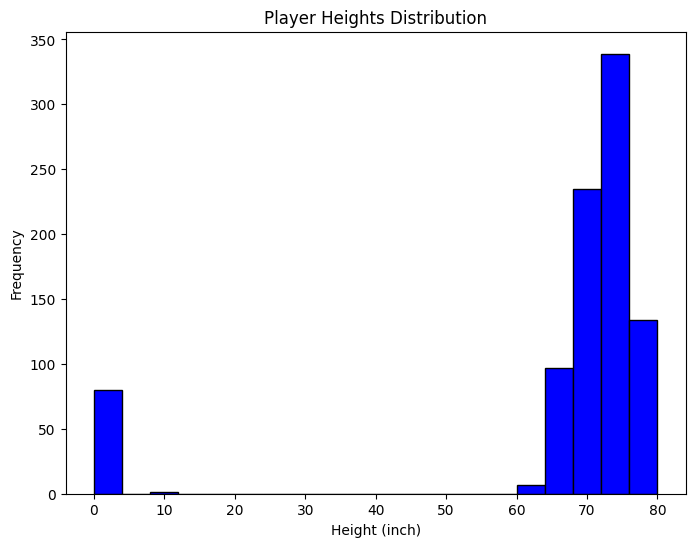

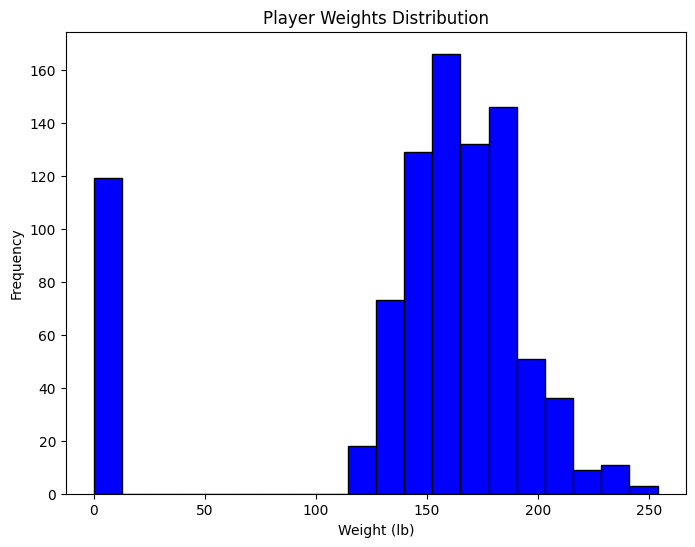

In [567]:
teams_df.dropna(inplace=True)
coaches_df.dropna(inplace=True)
players_df.dropna(inplace=True)
series_post_df.dropna(inplace=True)
players_teams_df.dropna(inplace=True)
awards_players_df.dropna(inplace=True)

plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

In [568]:
merged_data = players_df.merge(players_teams_df, left_on='bioId', right_on='playerID')
result = merged_data[merged_data['height'] == 0]

print(result)



Empty DataFrame
Columns: [bioId, pos, firstseason, lastseason, height, weight, college, collegeOther, birthDate, deathDate, playerID, year, stint, tmID, lgID, GP, GS, minutes, points, oRebounds, dRebounds, rebounds, assists, steals, blocks, turnovers, PF, fAttempted, fgMade, ftattempted, ftMade, threeAttempted, threeMade, dq, PostGP, PostGS, PostMinutes, PostPoints, PostoRebounds, PostdRebounds, PostRebounds, PostAssists, PostSteals, PostBlocks, PostTurnovers, PostPF, PostfgAttempted, PostfgMade, PostftAttempted, PostftMade, PostthreeAttempted, PostthreeMade, PostDQ]
Index: []

[0 rows x 53 columns]


Since the players that have 0 inches have all the other information as 0's and either are coaches or don't beleng to any team, we will drop them from the dataset.

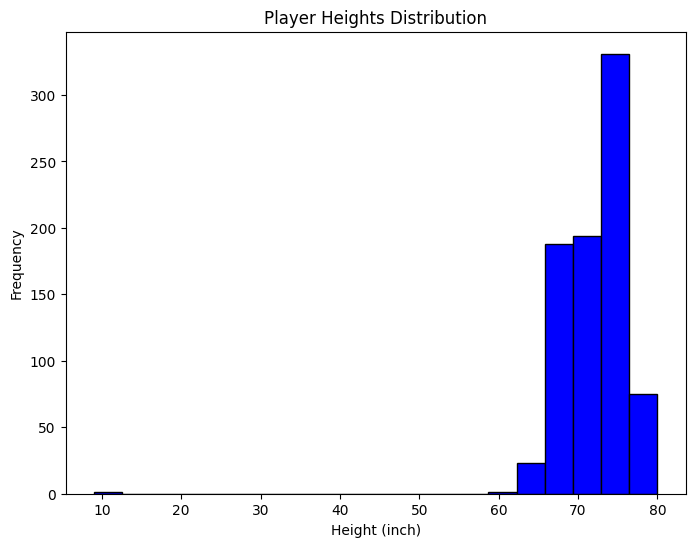

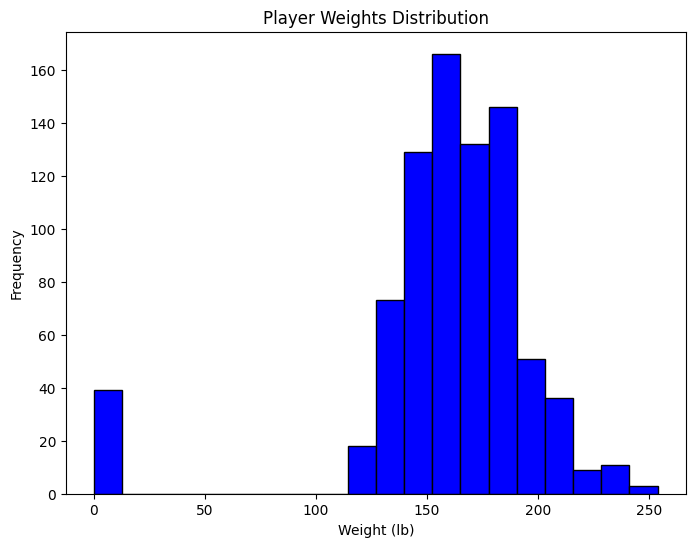

In [569]:
players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

As can be seen, even after taking out the players that have height as 0 and all the other columns as 0, there are still some players that have the weight as 0. To address this, we opted to replace the 0 value by the average weight of the players

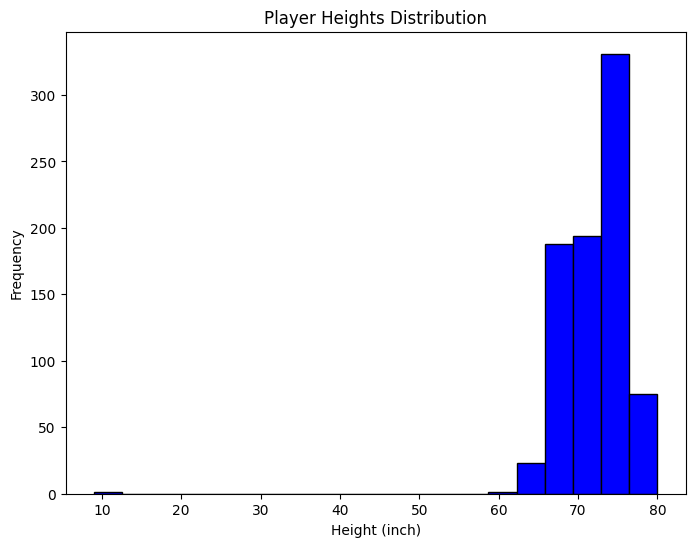

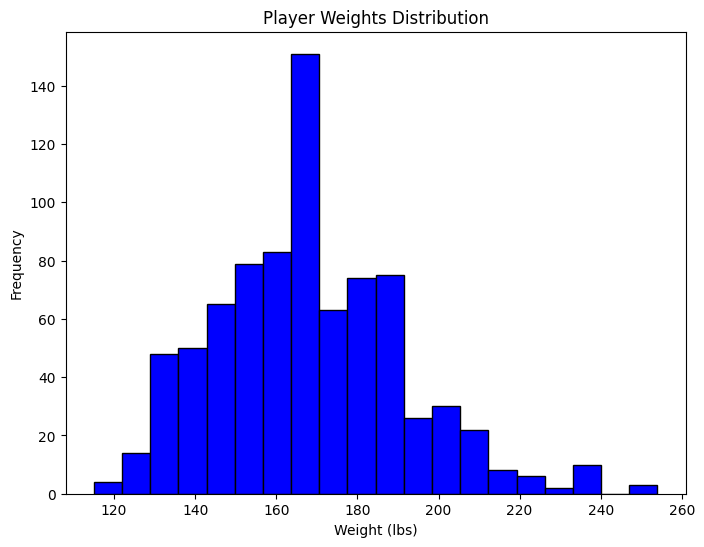

In [570]:
players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

mean_weight = players_df[players_df['weight'] > 0]['weight'].mean()

players_df.loc[players_df['weight'] == 0, 'weight'] = mean_weight


plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency')
plt.show()



As can be seen previously, there\'s still one player with a strange value in it's height.

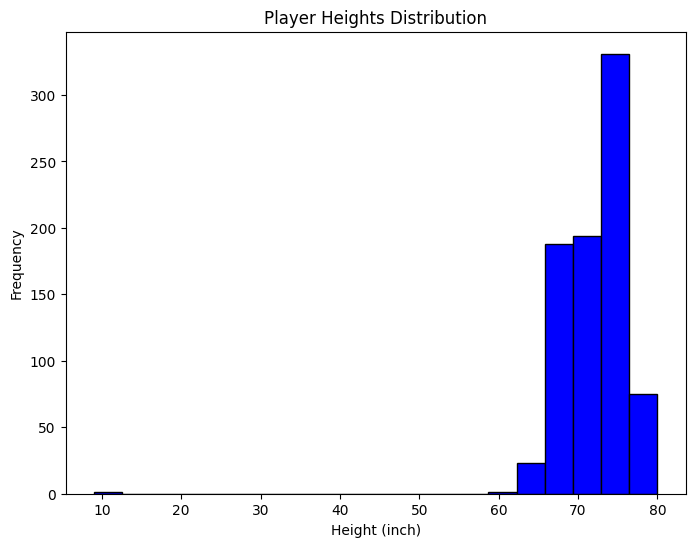

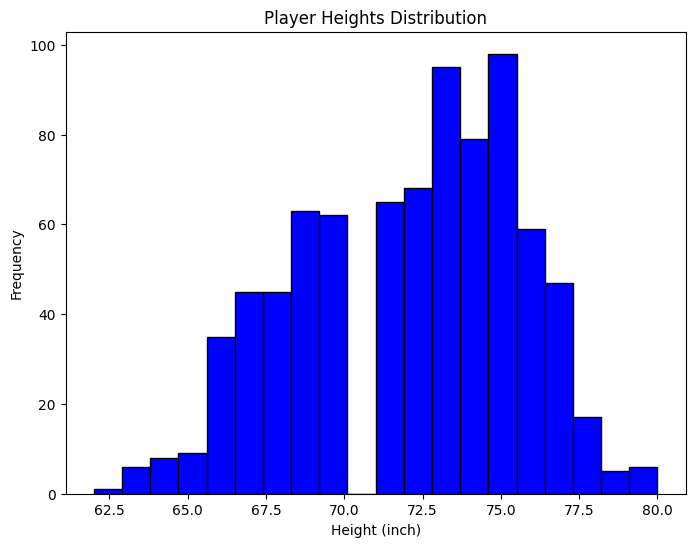

In [571]:
players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

mean_height = players_df[players_df['height'] > 10]['height'].mean()

players_df.loc[players_df['height'] < 10, 'height'] = mean_height

players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

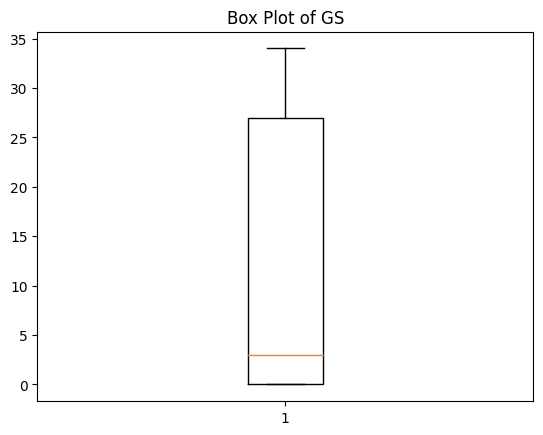

In [572]:
plt.boxplot(players_teams_df['GS'])
plt.title('Box Plot of GS')
plt.show()

As can be seen in the output, the dataset has no missing values so there's no need to replace any of them.

In [573]:
# Check for missing values
awards_players_missing = awards_players_df.isnull().sum()

coaches_missing = coaches_df.isnull().sum()

players_teams_missing = players_teams_df.isnull().sum()

players_missing = players_df.isnull().sum()

series_post_missing = series_post_df.isnull().sum()

teams_missing = teams_df.isnull().sum()

# Print the results for each DataFrame
print("Missing values in awards_players_df:")
print(awards_players_missing)

print("Missing values in coaches_df:")
print(coaches_missing)

print("Missing values in players_teams_df:")
print(players_teams_missing)

print("Missing values in players_df:")
print(players_missing)

print("Missing values in series_post_df:")
print(series_post_missing)

print("Missing values in teams_df:")
print(teams_missing)

Missing values in awards_players_df:
playerID    0
award       0
year        0
lgID        0
dtype: int64
Missing values in coaches_df:
coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64
Missing values in players_teams_df:
playerID              0
year                  0
stint                 0
tmID                  0
lgID                  0
GP                    0
GS                    0
minutes               0
points                0
oRebounds             0
dRebounds             0
rebounds              0
assists               0
steals                0
blocks                0
turnovers             0
PF                    0
fAttempted            0
fgMade                0
ftattempted           0
ftMade                0
threeAttempted        0
threeMade             0
dq                    0
PostGP                0
PostGS                0
PostMinutes           0
PostPoints    

Since we only want to know which teams are more likely to get to the playoffs, there is no need in having the information associated to the playoffs of the previous seasons. Therefore, the columns that contain this information will be dropped.

In [574]:
columns_to_drop = players_teams_df.filter(like='Post', axis=1).columns
players_teams_df = players_teams_df.drop(columns=columns_to_drop)
players_teams_df = players_teams_df.drop(columns=['lgID', 'stint'])

players_teams_df.head()

,playerID,year,tmID,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,MIN,26,23,846,343,43,131,174,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,MIN,27,27,805,314,45,101,146,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,MIN,30,25,792,318,44,97,141,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,MIN,22,11,462,146,17,57,74,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,MIN,31,31,777,304,29,78,107,...,6,80,86,276,109,73,53,82,33,0


As can be seen, there are no duplicate nor illogical values in the dataset, so there's no need to drop any of them.

In [575]:
duplicate_records = players_teams_df.duplicated(keep='first')

# Original DataFrame shape (before removing duplicates)
original_shape = players_teams_df.shape

# Shape of the DataFrame after removing duplicates
new_shape = duplicate_records.shape

# Calculate the number of duplicates dropped
duplicates_dropped = original_shape[0] - new_shape[0]

# Print the number of duplicates dropped
print(f"Number of duplicates dropped: {duplicates_dropped}")


illogical_records = players_teams_df[players_teams_df['GS'] > players_teams_df['GP']]
illogical_count = len(illogical_records)

print(f"Number of illogical values: {illogical_count}")

Number of duplicates dropped: 0
Number of illogical values: 0


There are only 3 players that did not have any minutes played in the season.

In [576]:
zero_gp_count = players_teams_df[players_teams_df['minutes'] == 0].groupby('year')['playerID'].count()

print(zero_gp_count)

players_teams_df.head()

year
9       3
11    148
Name: playerID, dtype: int64


,playerID,year,tmID,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,MIN,26,23,846,343,43,131,174,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,MIN,27,27,805,314,45,101,146,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,MIN,30,25,792,318,44,97,141,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,MIN,22,11,462,146,17,57,74,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,MIN,31,31,777,304,29,78,107,...,6,80,86,276,109,73,53,82,33,0


In the following block of code, for every player that participated in a season, the statistics of the previous season that he played in are added to the dataframe. On top of that, only the columns year, tmID, confID, attend and playoff are kept in the teams_df_clean dataframe.

In [577]:
teams_df_clean = teams_df[['year', 'tmID', 'confID', 'attend', 'playoff']]
players_df = players_df.drop(columns = ['lastseason', 'firstseason', 'deathDate', 'college', 'collegeOther'])

training_years = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

testing_set_with_stats = pd.DataFrame()

players_df = players_df.rename(columns={'bioId': 'playerID'})



for year in training_years:

    players_in_year = players_teams_df[players_teams_df['year'] == year]

    players_in_year = players_teams_df[players_teams_df['playerID'].isin(players_in_year['playerID'])]

    players_in_year = players_in_year[players_in_year['year'] < year]

    last_season_per_player = players_in_year.groupby('playerID')['year'].max().reset_index()

    last_season_stats = players_teams_df.merge(last_season_per_player, on=['playerID', 'year'], how='right')

    last_year_sum = last_season_stats.groupby('playerID').sum().reset_index()

    testing_set_for_year = last_year_sum.merge(players_df, on='playerID', how='left')

    # Add a 'year' column to indicate the year for which this data is used
    testing_set_for_year['year'] = year

    # Append the data for this year to the testing set DataFrame
    testing_set_with_stats = pd.concat([testing_set_with_stats, testing_set_for_year], ignore_index=True)

testing_set_with_stats.drop(columns=['tmID'], inplace=True)

players_teams_df= players_teams_df[['playerID', 'year', 'tmID']]

testing_set_with_stats = testing_set_with_stats.merge(players_teams_df, on=['playerID', 'year'], how='right')

An analysis was done to discover to each year, the season 1 corresponded. After analysing the data, it was discovered that the season 1 corresponded to the season 1999 due to the fact that the "WNBA All-Decade Team" award was only awarded one time in the whole history of the WNBA. Therefore, the year 1999 was used to calculate the age of each player.

In [578]:
testing_set_with_stats["birthDate"] = testing_set_with_stats["playerID"].map(players_df.set_index("playerID")["birthDate"])

testing_set_with_stats["height"] = testing_set_with_stats["playerID"].map(players_df.set_index("playerID")["height"])

testing_set_with_stats["weight"] = testing_set_with_stats["playerID"].map(players_df.set_index("playerID")["weight"])

testing_set_with_stats['birthDate'] = pd.to_datetime(testing_set_with_stats['birthDate'])

reference_year = 1999

testing_set_with_stats['age'] = reference_year + testing_set_with_stats['year']- testing_set_with_stats['birthDate'].dt.year


Regarding the age, weight and height of the players, the average of this metrics was calculated for each team and each season, using the players that played in each team that season. Regarding the other statistics, the sum was calculated for each team and each season.

In [579]:
agg_funcs = {
    'weight': 'mean', 
    'height': 'mean',  
    'age' : 'mean' 
}

# Group by 'tmID' and 'year' and apply the aggregation functions
mean_weight_height = testing_set_with_stats.groupby(['tmID', 'year']).agg(agg_funcs).reset_index()

mean_weight_height = mean_weight_height.round(2)

testing_set_with_stats = testing_set_with_stats.drop(columns=['birthDate', 'height', 'weight', 'age'])

testing_set_with_stats.drop(columns=['playerID', 'pos'], inplace=True)

team_year_averages = testing_set_with_stats.groupby(['tmID', 'year']).sum().reset_index()

team_year_averages = team_year_averages.round(2)

teams_df_clean = teams_df_clean.merge(team_year_averages, on = ['year', 'tmID'], how ='left')


Merge the dataframes "mean_weight_height" and "team_year_averages" into the dataframe "teams_df_clean"

In [580]:
teams_df_clean = teams_df_clean.merge(mean_weight_height, on = ['year', 'tmID'], how ='left')
teams_df_clean.head()

,year,tmID,confID,attend,playoff,GP,GS,minutes,points,oRebounds,...,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq,weight,height,age
0,9,ATL,EA,141379,N,300.0,97.0,5141.0,1769.0,250.0,...,1556.0,647.0,377.0,288.0,491.0,187.0,2.0,168.714286,73.214286,25.571429
1,10,ATL,EA,120737,Y,308.0,194.0,6972.0,2421.0,396.0,...,2149.0,884.0,717.0,506.0,459.0,147.0,11.0,159.076923,72.538462,26.615385
2,1,CHA,EA,90963,N,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.846154,71.692308,26.538462
3,2,CHA,EA,105525,Y,260.0,122.0,5729.0,1959.0,219.0,...,1668.0,686.0,552.0,425.0,511.0,162.0,6.0,164.416667,71.5,26.75
4,3,CHA,EA,106670,Y,338.0,179.0,6931.0,2155.0,340.0,...,1893.0,772.0,595.0,453.0,449.0,158.0,7.0,164.923077,71.307692,27.769231


A certain amount of points was assigned to each award, depending on the importance of the award. After that, the points were summed for each player until the season that is being analysed. The points were then summed for each team and each season, depending on the players that played in each team that season.

In [581]:
awards_players_df = awards_players_df.rename(columns={'Kim Perrot Sportsmanship': 'Kim Perrot Sportsmanship Award'})


award_points =  {
    "All-Star Game Most Valuable Player": 2,
    "Defensive Player of the Year": 4,
    "Kim Perrot Sportsmanship Award": 1,
    "Most Improved Player": 2,
    "Most Valuable Player": 5,
    "Rookie of the Year": 3,
    "Sixth Woman of the Year": 2,
    "WNBA Finals Most Valuable Player": 4,
    "WNBA All-Decade Team": 1,
    "WNBA All Decade Team Honorable Mention": 1,
}

relevant_awards = awards_players_df[awards_players_df['award'].isin(award_points.keys())]

awards_players_teams = relevant_awards.merge(players_teams_df, on=['playerID', 'year'], how='left')

awards_players_teams['award_points'] = awards_players_teams['award'].map(award_points)

years_of_interest = [2,3,4,5,6,7,8,9,10,11] 

# Initialize an empty DataFrame to store the results
player_award_points = pd.DataFrame()


for year in years_of_interest: 
    
    previous_awards = awards_players_teams[awards_players_teams['year'] < year]

    player_yearly_award_points = previous_awards.groupby(['playerID'])['award_points'].sum().reset_index()

    player_yearly_award_points['year'] = year

    player_award_points = pd.concat([player_award_points, player_yearly_award_points], ignore_index=True)

player_award_points = player_award_points.merge(players_teams_df, on=['playerID', 'year'], how='left')

player_award_points = player_award_points.dropna(subset=['tmID'])

player_award_points = player_award_points.groupby(['tmID', 'year']).sum().reset_index()

teams_df_clean = teams_df_clean.merge(player_award_points, on = ['year', 'tmID'], how ='left')

teams_df_clean.drop(columns=['playerID'], inplace=True)

teams_df_clean.fillna(0, inplace=True)

teams_df_clean.head()


,year,tmID,confID,attend,playoff,GP,GS,minutes,points,oRebounds,...,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq,weight,height,age,award_points
0,9,ATL,EA,141379,N,300.0,97.0,5141.0,1769.0,250.0,...,647.0,377.0,288.0,491.0,187.0,2.0,168.714286,73.214286,25.571429,7.0
1,10,ATL,EA,120737,Y,308.0,194.0,6972.0,2421.0,396.0,...,884.0,717.0,506.0,459.0,147.0,11.0,159.076923,72.538462,26.615385,10.0
2,1,CHA,EA,90963,N,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.846154,71.692308,26.538462,0.0
3,2,CHA,EA,105525,Y,260.0,122.0,5729.0,1959.0,219.0,...,686.0,552.0,425.0,511.0,162.0,6.0,164.416667,71.5,26.75,0.0
4,3,CHA,EA,106670,Y,338.0,179.0,6931.0,2155.0,340.0,...,772.0,595.0,453.0,449.0,158.0,7.0,164.923077,71.307692,27.769231,0.0


For each team and each season, the number of wins and loses were calculated, regarding the last season that the coach has partipated. After that, this was added to the dataframe "teams_df_clean".

In [582]:
coaches_record = pd.DataFrame()

for year in training_years:
    coaches_in_year = coaches_df[coaches_df['year'] == year]

    previous_season = coaches_df[coaches_df['year'] < year]

    filtered_previous_season = previous_season[previous_season['coachID'].isin(coaches_in_year['coachID'])]

    last_season_per_coach = filtered_previous_season.groupby('coachID')['year'].max().reset_index()

    last_season_stats = coaches_df.merge(last_season_per_coach, on=['coachID', 'year'], how='right')

    coaches_in_year = coaches_in_year[['coachID', 'tmID']]

    last_season_stats = last_season_stats.drop(columns=['tmID'])

    last_season_stats = last_season_stats.merge(coaches_in_year, on=['coachID'], how='right')

    last_year_sum = last_season_stats.groupby('coachID').sum().reset_index()

    last_year_sum['year'] = year

    last_year_sum.drop(columns=['coachID', 'lgID', 'stint', 'post_wins', 'post_losses'], inplace=True)

    last_year_sum = last_year_sum.groupby('tmID').mean().reset_index()

    last_year_sum.rename(columns={'won': 'coachW', 'lost': 'coachL'}, inplace=True)

    coaches_record = pd.concat([coaches_record, last_year_sum], ignore_index=True)
    
teams_df_clean = teams_df_clean.merge(coaches_record, on=['year', 'tmID'], how='left')

teams_df_clean.fillna(0, inplace=True)





The same logic that was used for the players awards was used for the coaches awards.

In [583]:
coach_points =  {
    "Coach of the Year": 3,
}
coaches_df_clean = coaches_df.copy()

coach_awards = awards_players_df[awards_players_df["award"] == "Coach of the Year"]
coach_awards.drop(columns=['lgID'], inplace=True)
coaches_df_clean.drop(columns=['lgID', 'stint', "won","lost","post_wins","post_losses", "tmID"], inplace=True)
coach_awards.rename(columns={'playerID': 'coachID'}, inplace=True)
coach_awards = coach_awards.merge(coaches_df_clean, on=['coachID', 'year'], how='left')
coach_awards['award_points'] = coach_awards['award'].map(coach_points)
coach_awards.drop(columns=['award'], inplace=True)


awards_year = pd.DataFrame()

for year in years_of_interest: 
    
    previous_awards = coach_awards[coach_awards['year'] < year]

    coach_yearly_award_points = previous_awards.groupby(['coachID'])['award_points'].sum().reset_index()

    coach_yearly_award_points['year'] = year

    awards_year = pd.concat([awards_year, coach_yearly_award_points], ignore_index=True)



awards_year = awards_year.merge(coaches_df[["year", "coachID", "tmID"]], on=['coachID', 'year'], how='left')

awards_year.drop(columns=['coachID'], inplace=True)

awards_year = awards_year.dropna(subset=['tmID'])

teams_df_clean = teams_df_clean.merge(awards_year, on=['year', 'tmID'], suffixes=('_df1', '_df2'), how='left')

teams_df_clean.fillna(0, inplace=True)

teams_df_clean['combined_awards_points'] = teams_df_clean['award_points_df1'] + teams_df_clean['award_points_df2']

teams_df_clean.drop(columns=['award_points_df1', 'award_points_df2'], inplace=True)

teams_df_clean.rename(columns={'combined_awards_points': 'awards_points'}, inplace=True)






/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_39491/2827065444.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coach_awards.drop(columns=['lgID'], inplace=True)
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_39491/2827065444.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coach_awards.rename(columns={'playerID': 'coachID'}, inplace=True)


A normalization was done to the data, so that the data would be in the same scale. This approach improves the results of the linear regression model. The columns that were excluded from the normalization were the columns that had the teamID, the conferenceID, the year, the playoff, the weight, the age and the height. On top of that, an encoding was done to the columns that had the teamID, the conferenceID and playoff.

In [584]:
teams_df_clean.drop(columns=['attend'], inplace=True)
columns_to_exclude = ['year', 'tmID', 'confID', 'playoff', 'weight','age','height']

columns_to_normalize = [col for col in teams_df_clean.columns if col not in columns_to_exclude]

le = LabelEncoder()
teams_df_clean['confID'] = le.fit_transform(teams_df_clean['confID'])
teams_df_clean['playoff'].replace({'N': 0, 'Y': 1}, inplace=True)
teams_df_clean['tmID'] = le.fit_transform(teams_df_clean['tmID'])

teams_df_clean_normalize = teams_df_clean.copy()

teams_df_clean_normalize[columns_to_normalize] = (teams_df_clean_normalize[columns_to_normalize] - teams_df_clean_normalize[columns_to_normalize].mean()) / teams_df_clean_normalize[columns_to_normalize].std()

teams_df_clean= teams_df_clean_normalize.copy()


In [585]:
target_year = 10
training_set = teams_df_clean[(teams_df_clean['year'] < target_year)]
training_set_W = training_set[training_set['confID'] == 0]
training_set_E = training_set[training_set['confID'] == 1]

testing_set = teams_df_clean[teams_df_clean['year'] >= target_year]
testing_set = testing_set[teams_df_clean['year'] < 11]
testing_set_W = testing_set[testing_set['confID'] == 0]
testing_set_E = testing_set[testing_set['confID'] == 1]


X_train_W = training_set_W.drop(columns = "playoff", axis = 1)
y_train_W = training_set_W['playoff']
X_train_E = training_set_E.drop(columns = "playoff", axis = 1)
y_train_E = training_set_E['playoff']

X_test_W = testing_set_W.drop(columns = "playoff", axis = 1)
y_test_W = testing_set_W['playoff']
X_test_E = testing_set_E.drop(columns = "playoff", axis = 1)
y_test_E = testing_set_E['playoff']


/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_39491/3176315914.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing_set = testing_set[teams_df_clean['year'] < 11]


The linear regression model was applied, but before that, the data was split into confereces, so that the model would be more accurate. The model was applied to the data of the Eastern Conference and the Western Conference, since each conference qualifies 4 teams to the playoffs.

/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_39491/3851086006.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing_set_normalize = testing_set_normalize[teams_df_clean['year'] < 11]
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown 

[1 0 1 1 1 0 0]
[1 0 1 0 1 1]


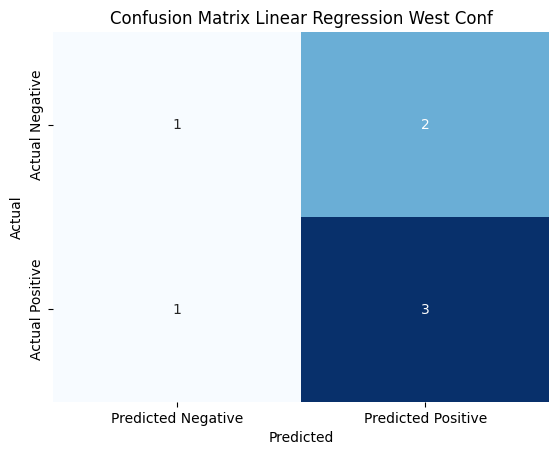

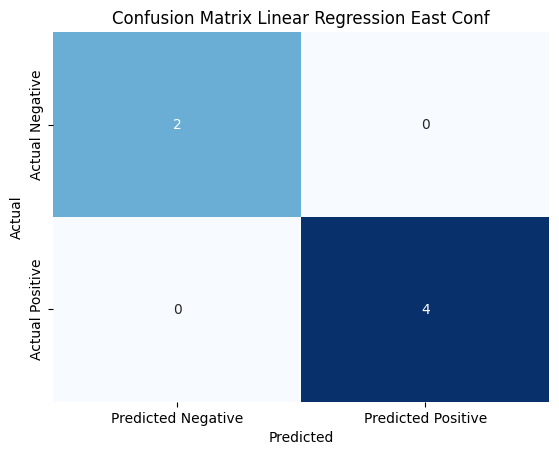

Accuracy_W: 0.57
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7

Accuracy_E: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



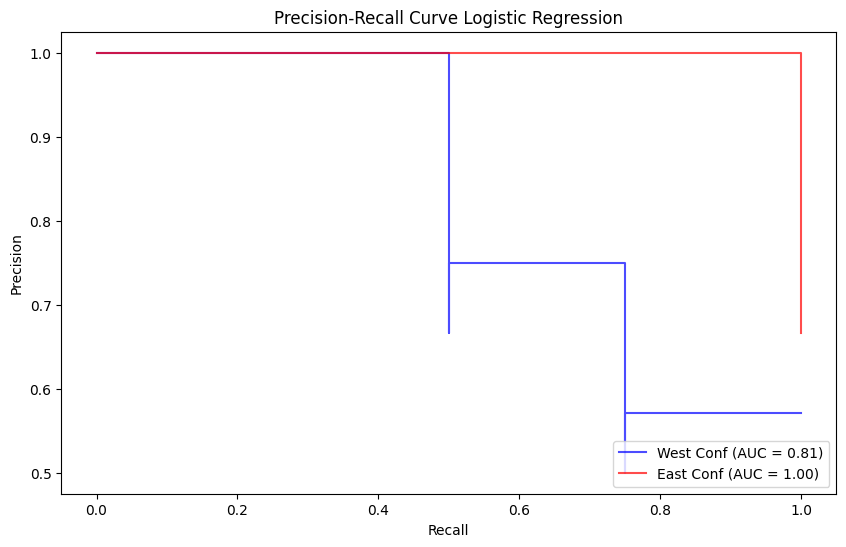

In [586]:
training_set_normalize = teams_df_clean_normalize[(teams_df_clean_normalize['year'] < target_year)]
training_set_normalize_W = teams_df_clean_normalize[(teams_df_clean_normalize['confID'] == 0)]
training_set_normalize_E = teams_df_clean_normalize[(teams_df_clean_normalize['confID'] == 1)]


testing_set_normalize = teams_df_clean_normalize[teams_df_clean['year'] >= target_year]
testing_set_normalize = testing_set_normalize[teams_df_clean['year'] < 11]
testing_set_normalize_W = testing_set_normalize[(testing_set_normalize['confID'] == 0)]
testing_set_normalize_E = testing_set_normalize[(testing_set_normalize['confID'] == 1)]


X_train_normalize_W = training_set_normalize_W.drop(columns = "playoff", axis = 1)
y_train_normalize_W = training_set_normalize_W['playoff']
X_train_normalize_E = training_set_normalize_E.drop(columns = "playoff", axis = 1)
y_train_normalize_E = training_set_normalize_E['playoff']


X_test_normalize_W = testing_set_normalize_W.drop(columns = "playoff", axis = 1)
y_test_normalize_W = testing_set_normalize_W['playoff']
X_test_normalize_E = testing_set_normalize_E.drop(columns = "playoff", axis = 1)
y_test_normalize_E = testing_set_normalize_E['playoff']


logistic_regression = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500, 1000, 1500],
    'fit_intercept': [True, False]
}

grid_search_W = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search_E = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

grid_search_W.fit(X_train_normalize_W, y_train_normalize_W)
grid_search_E.fit(X_train_normalize_E, y_train_normalize_E)

best_params_W = grid_search_W.best_params_
best_model_W = grid_search_W.best_estimator_
best_params_E = grid_search_E.best_params_
best_model_E = grid_search_E.best_estimator_

best_model_W.fit(X_train_normalize_W, y_train_normalize_W)
best_model_E.fit(X_train_normalize_E, y_train_normalize_E)

y_probabilities_W = best_model_W.predict_proba(X_test_normalize_W)[:, 1]
y_probabilities_E = best_model_E.predict_proba(X_test_normalize_E)[:, 1]


predictions_W = best_model_W.predict(X_test_normalize_W)
predictions_E = best_model_E.predict(X_test_normalize_E)


top_4_indices_W = np.argsort(y_probabilities_W)[-4:]
limited_predictions_W = np.zeros_like(predictions_W)
limited_predictions_W[top_4_indices_W] = 1
print(limited_predictions_W)

top_4_indices_E = np.argsort(y_probabilities_E)[-4:]
limited_predictions_E = np.zeros_like(predictions_E)
limited_predictions_E[top_4_indices_E] = 1
print(limited_predictions_E)

results_df_W = pd.DataFrame({
    'ConfID': testing_set_normalize_W['confID'].tolist(),
    'Probabilities': y_probabilities_W,
    'Predicted': limited_predictions_W,
    'Actual': y_test_normalize_W.tolist(),
    'tmID': testing_set_normalize_W['tmID'].tolist()
})

results_df_E = pd.DataFrame({
    'ConfID': testing_set_normalize_E['confID'].tolist(),
    'Probabilities': y_probabilities_E,
    'Predicted': limited_predictions_E,
    'Actual': y_test_normalize_E.tolist(),
    'tmID': testing_set_normalize_E['tmID'].tolist()
})


# Concatenate the DataFrames
results_df = pd.concat([results_df_W, results_df_E], ignore_index=True)

results_df['tmID'] = le.inverse_transform(results_df['tmID'])

# Generate the confusion matrix
conf_matrix_W = confusion_matrix(y_test_normalize_W, predictions_W)
conf_matrix_E = confusion_matrix(y_test_normalize_E, predictions_E)

# Plot the confusion matrix using seaborn
sb.heatmap(conf_matrix_W, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Linear Regression West Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sb.heatmap(conf_matrix_E, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Linear Regression East Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


accuracy_W = accuracy_score(y_test_normalize_W, predictions_W)
classification_rep_W = classification_report(y_test_normalize_W, predictions_W)
print(f'Accuracy_W: {accuracy_W:.2f}')
print(classification_rep_W)

accuracy_E = accuracy_score(y_test_normalize_E, predictions_E)
classification_rep_E = classification_report(y_test_normalize_E, predictions_E)
print(f'Accuracy_E: {accuracy_E:.2f}')
print(classification_rep_E)


# Compute precision-recall curve and area the curve
precision_W, recall_W, _ = precision_recall_curve(y_test_normalize_W, y_probabilities_W)
precision_E, recall_E, _ = precision_recall_curve(y_test_normalize_E, y_probabilities_E)

# Compute area under the curve
area_under_curve_W = auc(recall_W, precision_W)
area_under_curve_E = auc(recall_E, precision_E)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_W, precision_W, color='b', alpha=0.7, where='post', label=f'West Conf (AUC = {area_under_curve_W:.2f})')
plt.step(recall_E, precision_E, color='r', alpha=0.7, where='post', label=f'East Conf (AUC = {area_under_curve_E:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Logistic Regression')
plt.legend(loc='lower right')
plt.show()


{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classif

Accuracy_W: 0.57
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      1.00      0.73         4

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7

Accuracy_E: 0.67
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



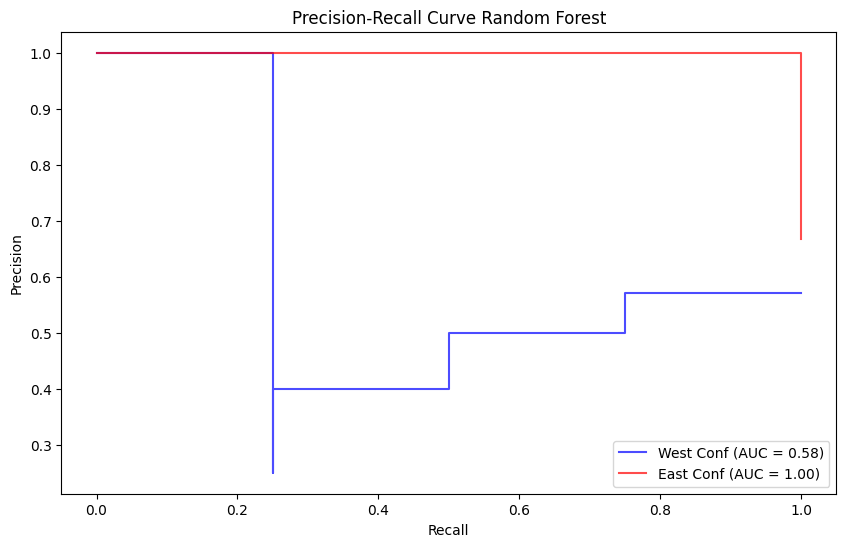

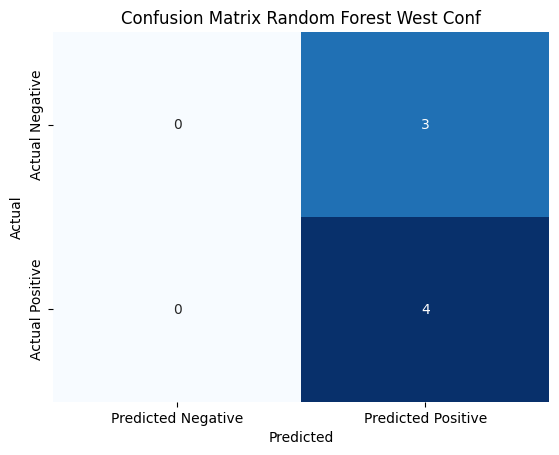

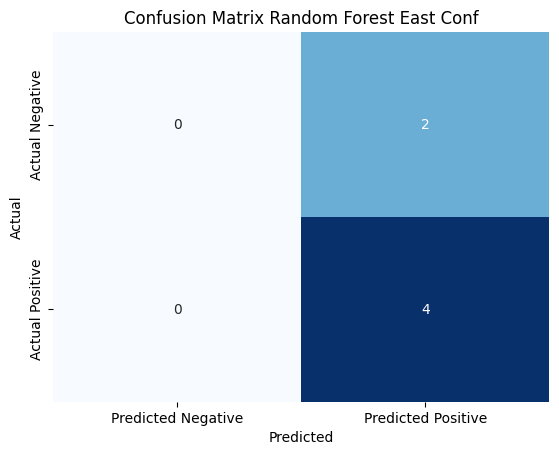

In [587]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy']
}

grid_search_W = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search_E = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

grid_search_W.fit(X_train_W, y_train_W)
grid_search_E.fit(X_train_E, y_train_E)

print(grid_search_W.best_params_)
print(grid_search_E.best_params_)

best_params_W = grid_search_W.best_params_
best_model_W = grid_search_W.best_estimator_
best_params_E = grid_search_E.best_params_
best_model_E = grid_search_E.best_estimator_

best_model_W.fit(X_train_W, y_train_W)
best_model_E.fit(X_train_E, y_train_E)


y_probabilities_W = best_model_W.predict_proba(X_test_W)[:, 1]
y_probabilities_E = best_model_E.predict_proba(X_test_E)[:, 1]


predictions_W = best_model_W.predict(X_test_normalize_W)
predictions_E = best_model_E.predict(X_test_normalize_E)


top_4_indices_W = np.argsort(y_probabilities_W)[-4:]
limited_predictions_W = np.zeros_like(predictions_W)
limited_predictions_W[top_4_indices_W] = 1

top_4_indices_E = np.argsort(y_probabilities_E)[-4:]
limited_predictions_E = np.zeros_like(predictions_E)
limited_predictions_E[top_4_indices_E] = 1

results_df_W = pd.DataFrame({
    'ConfID': testing_set_normalize_W['confID'].tolist(),
    'Probabilities': y_probabilities_W,
    'Predicted': limited_predictions_W,
    'Actual': y_test_normalize_W.tolist(),
    'tmID': testing_set_normalize_W['tmID'].tolist()
})

results_df_E = pd.DataFrame({
    'ConfID': testing_set_normalize_E['confID'].tolist(),
    'Probabilities': y_probabilities_E,
    'Predicted': limited_predictions_E,
    'Actual': y_test_normalize_E.tolist(),
    'tmID': testing_set_normalize_E['tmID'].tolist()
})

# Concatenate the DataFrames
results_df = pd.concat([results_df_W, results_df_E], ignore_index=True)

results_df['tmID'] = le.inverse_transform(results_df['tmID'])

accuracy_W = accuracy_score(y_test_normalize_W, predictions_W)
classification_rep_W = classification_report(y_test_normalize_W, predictions_W)
print(f'Accuracy_W: {accuracy_W:.2f}')
print(classification_rep_W)

accuracy_E = accuracy_score(y_test_normalize_E, predictions_E)
classification_rep_E = classification_report(y_test_normalize_E, predictions_E)
print(f'Accuracy_E: {accuracy_E:.2f}')
print(classification_rep_E)


# Compute precision-recall curve and area the curve
precision_W, recall_W, _ = precision_recall_curve(y_test_W, y_probabilities_W)
precision_E, recall_E, _ = precision_recall_curve(y_test_E, y_probabilities_E)

# Compute area under the curve
area_under_curve_W = auc(recall_W, precision_W)
area_under_curve_E = auc(recall_E, precision_E)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_W, precision_W, color='b', alpha=0.7, where='post', label=f'West Conf (AUC = {area_under_curve_W:.2f})')
plt.step(recall_E, precision_E, color='r', alpha=0.7, where='post', label=f'East Conf (AUC = {area_under_curve_E:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Random Forest')
plt.legend(loc='lower right')
plt.show()

conf_matrix_W = confusion_matrix(y_test_W, predictions_W)
conf_matrix_E = confusion_matrix(y_test_E, predictions_E)

# Plot the confusion matrix using seaborn
sb.heatmap(conf_matrix_W, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Random Forest West Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sb.heatmap(conf_matrix_E, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Random Forest East Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Accuracy: 0.57
AUC: 0.58
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7

Accuracy: 0.83
AUC: 0.94
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.80      1.00      0.89         4

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6



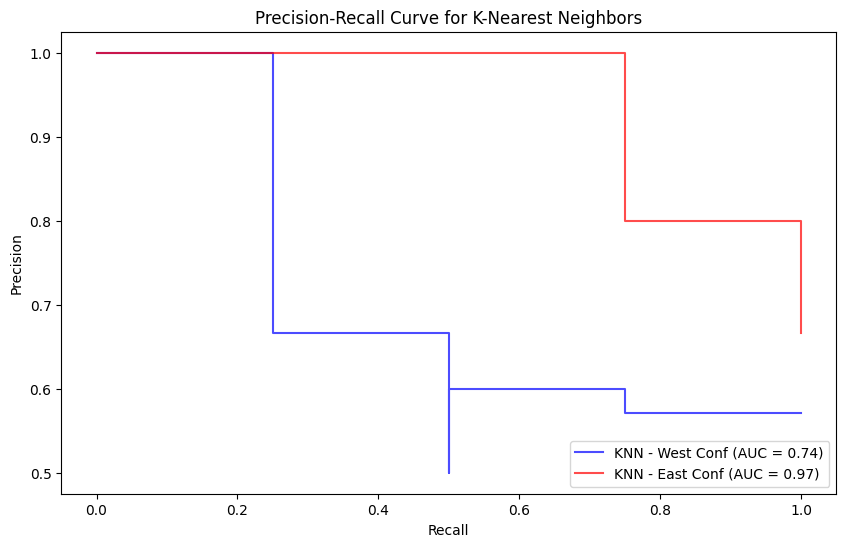

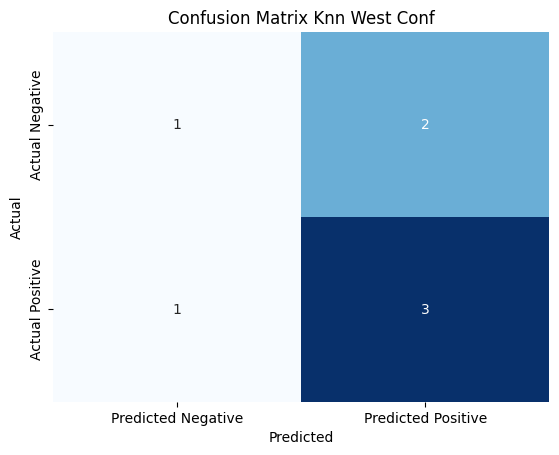

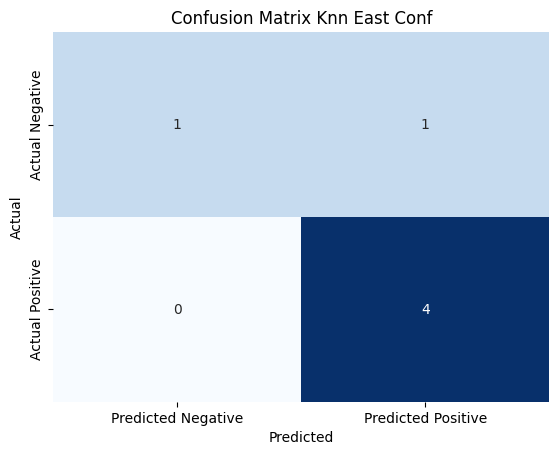

In [588]:
knn_classifier_W = KNeighborsClassifier(n_neighbors=10)
knn_classifier_E = KNeighborsClassifier(n_neighbors=10)

knn_classifier_W.fit(X_train_W, y_train_W)
knn_classifier_E.fit(X_train_E, y_train_E)

predictions_W = knn_classifier_W.predict(X_test_W)
predictions_E = knn_classifier_E.predict(X_test_E)

y_probabilities_W = knn_classifier_W.predict_proba(X_test_W)[:, 1]
y_probabilities_E = knn_classifier_E.predict_proba(X_test_E)[:, 1]

auc_score_W = roc_auc_score(y_test_W, y_probabilities_W)
auc_score_E = roc_auc_score(y_test_E, y_probabilities_E)

accuracy_W = accuracy_score(y_test_W, predictions_W)
classification_rep_W = classification_report(y_test_W, predictions_W)
print(f'Accuracy: {accuracy_W:.2f}')
print(f'AUC: {auc_score_W:.2f}')
print(classification_rep_W)

accuracy_E = accuracy_score(y_test_E, predictions_E)
classification_rep_E = classification_report(y_test_E, predictions_E)
print(f'Accuracy: {accuracy_E:.2f}')
print(f'AUC: {auc_score_E:.2f}')
print(classification_rep_E)

# K-Nearest Neighbors - West Conf
y_probabilities_W_knn = knn_classifier_W.predict_proba(X_test_W)[:, 1]
precision_W_knn, recall_W_knn, _ = precision_recall_curve(y_test_W, y_probabilities_W_knn)
area_under_curve_W_knn = auc(recall_W_knn, precision_W_knn)

# K-Nearest Neighbors - East Conf
y_probabilities_E_knn = knn_classifier_E.predict_proba(X_test_E)[:, 1]
precision_E_knn, recall_E_knn, _ = precision_recall_curve(y_test_E, y_probabilities_E_knn)
area_under_curve_E_knn = auc(recall_E_knn, precision_E_knn)

# Plot precision-recall curve for K-Nearest Neighbors - West Conf
plt.figure(figsize=(10, 6))
plt.step(recall_W_knn, precision_W_knn, color='b', alpha=0.7, where='post', label=f'KNN - West Conf (AUC = {area_under_curve_W_knn:.2f})')

# Plot precision-recall curve for K-Nearest Neighbors - East Conf
plt.step(recall_E_knn, precision_E_knn, color='r', alpha=0.7, where='post', label=f'KNN - East Conf (AUC = {area_under_curve_E_knn:.2f})')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for K-Nearest Neighbors')
plt.legend(loc='lower right')
plt.show()

conf_matrix_W = confusion_matrix(y_test_W, predictions_W)
conf_matrix_E = confusion_matrix(y_test_E, predictions_E)

# Plot the confusion matrix using seaborn
sb.heatmap(conf_matrix_W, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Knn West Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sb.heatmap(conf_matrix_E, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Knn East Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.29
AUC: 0.25
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      0.50      0.44         4

    accuracy                           0.29         7
   macro avg       0.20      0.25      0.22         7
weighted avg       0.23      0.29      0.25         7

Accuracy: 0.67
AUC: 0.62
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.75      0.75      0.75         4

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6



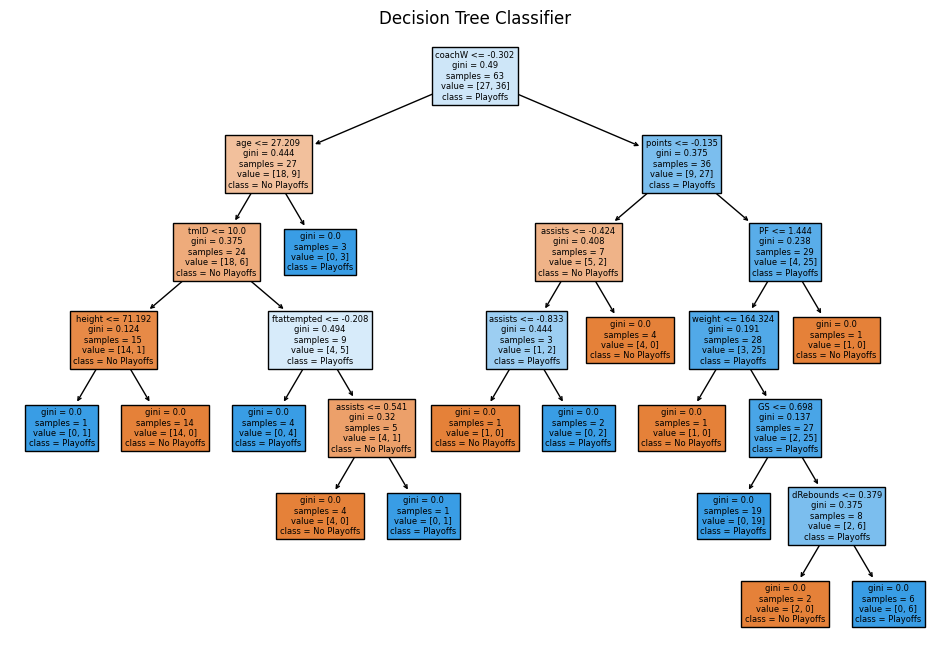

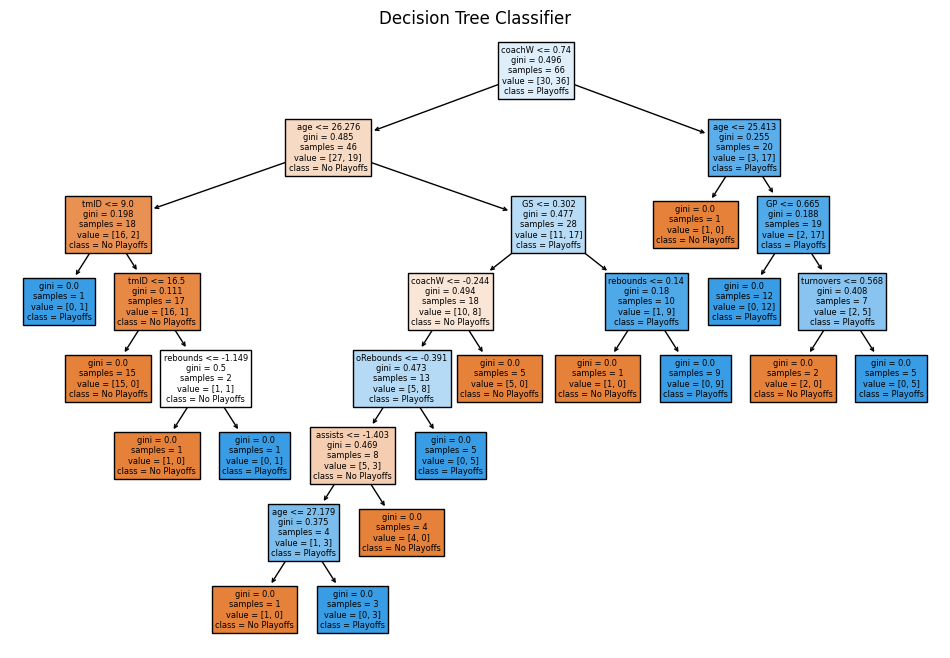

                    year      tmID    confID   playoff        GP        GS  \
year            1.000000 -0.036568 -0.005089  0.091904  0.489259  0.415798   
tmID           -0.036568  1.000000  0.421525 -0.003671 -0.064349 -0.046434   
confID         -0.005089  0.421525  1.000000 -0.014997 -0.025833 -0.000810   
playoff         0.091904 -0.003671 -0.014997  1.000000  0.081164  0.201617   
GP              0.489259 -0.064349 -0.025833  0.081164  1.000000  0.852140   
GS              0.415798 -0.046434 -0.000810  0.201617  0.852140  1.000000   
minutes         0.454598 -0.068338 -0.022299  0.167761  0.959067  0.950453   
points          0.556673 -0.043215  0.035532  0.202080  0.912577  0.923126   
oRebounds       0.460732 -0.056266 -0.056942  0.176142  0.920645  0.895011   
dRebounds       0.550388 -0.059094  0.030573  0.233515  0.917906  0.914734   
rebounds        0.528321 -0.058889  0.003075  0.217998  0.929573  0.919213   
assists         0.491722 -0.088803  0.024224  0.235979  0.896739

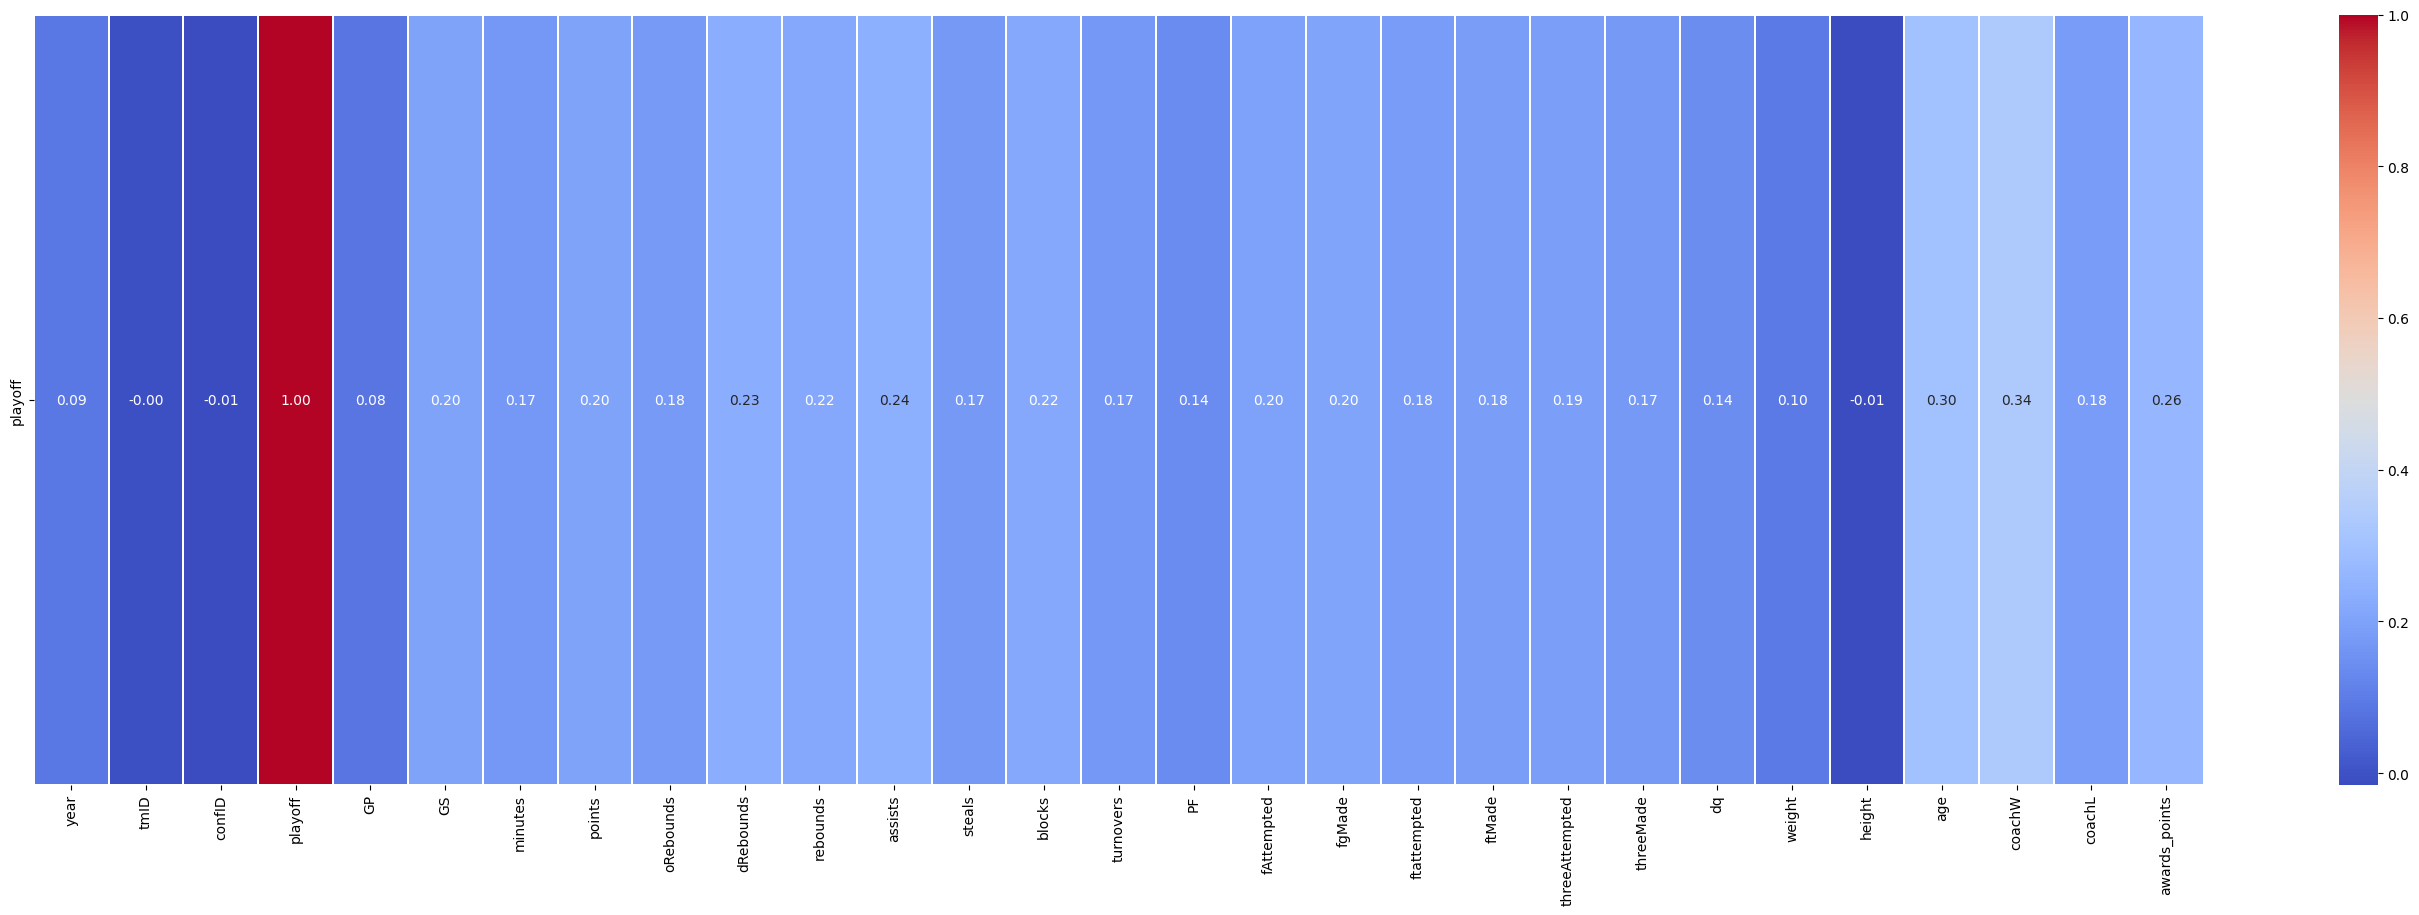

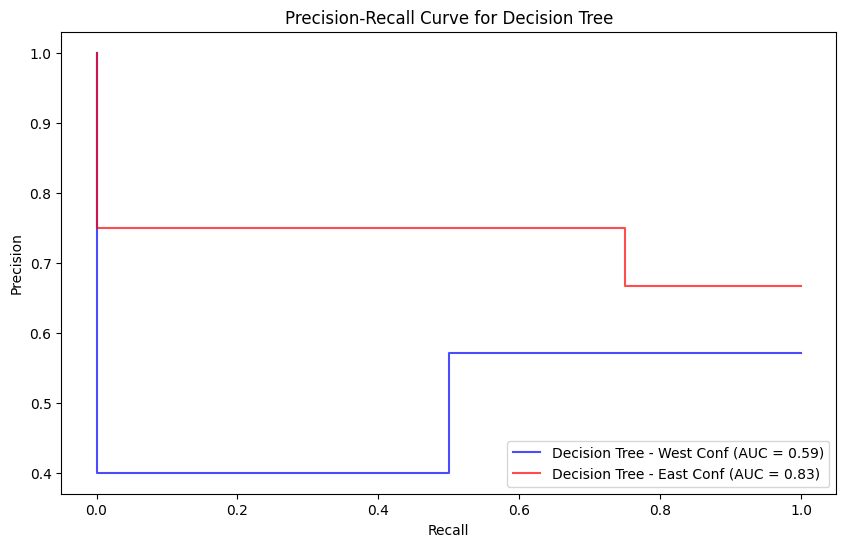

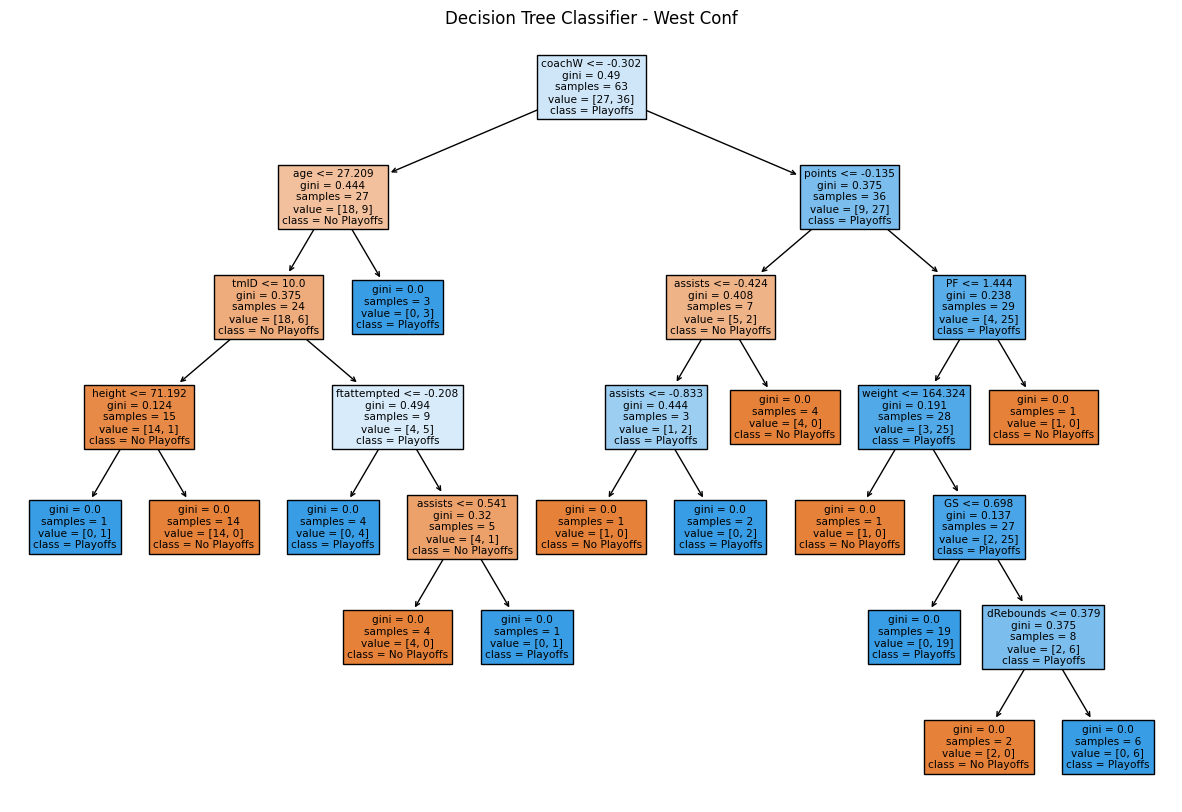

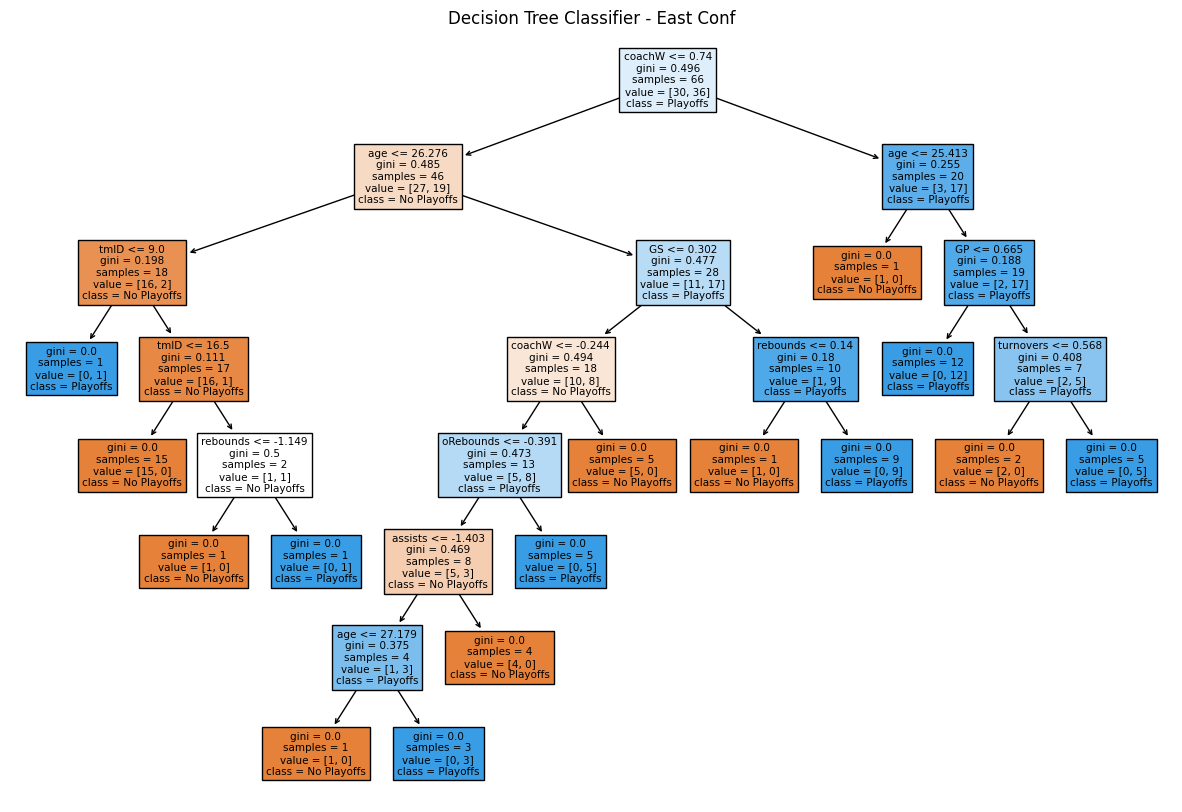

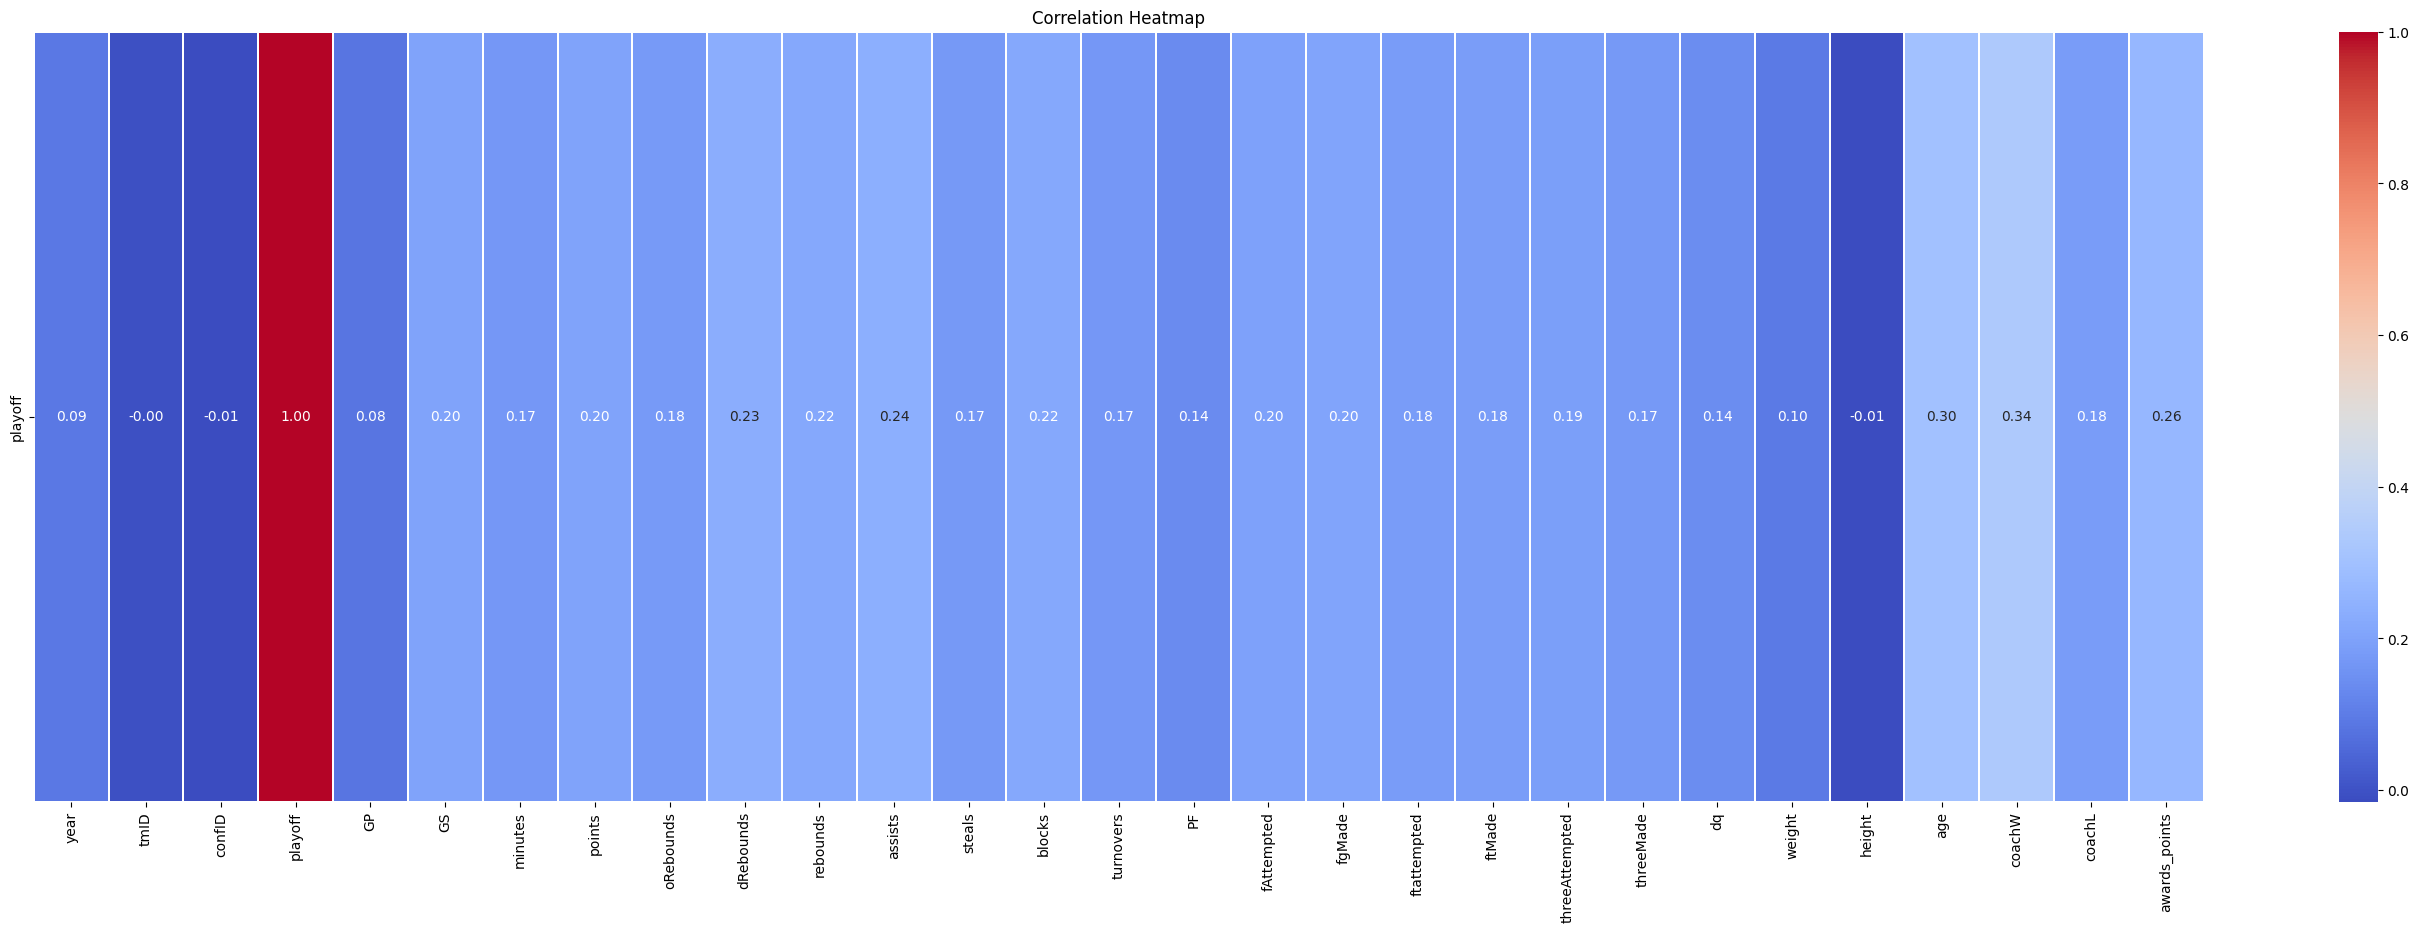

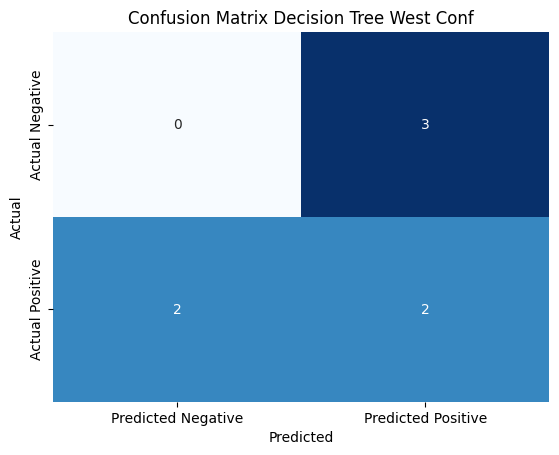

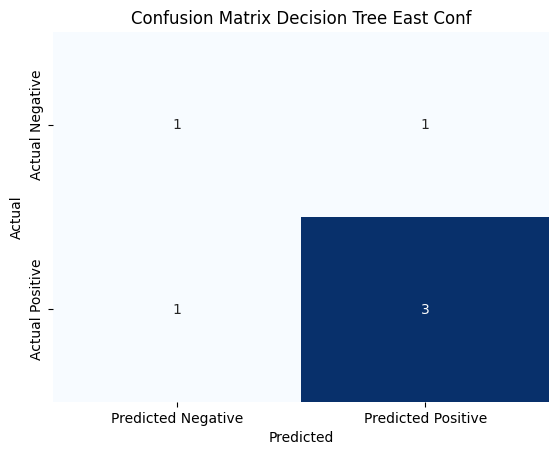

In [589]:
decision_tree_classifier_W = DecisionTreeClassifier(random_state=10)
decision_tree_classifier_E = DecisionTreeClassifier(random_state=10)

decision_tree_classifier_W.fit(X_train_W, y_train_W)
decision_tree_classifier_E.fit(X_train_E, y_train_E)

predictions_W = decision_tree_classifier_W.predict(X_test_W)
predictions_E = decision_tree_classifier_E.predict(X_test_E)

y_probabilities_W = decision_tree_classifier_W.predict_proba(X_test_W)[:, 1]
y_probabilities_E = decision_tree_classifier_E.predict_proba(X_test_E)[:, 1]

auc_score_W = roc_auc_score(y_test_W, y_probabilities_W)
auc_score_E = roc_auc_score(y_test_E, y_probabilities_E)

accuracy_W = accuracy_score(y_test_W, predictions_W)
classification_rep_W = classification_report(y_test_W, predictions_W)
print(f'Accuracy: {accuracy_W:.2f}')
print(f'AUC: {auc_score_W:.2f}')
print(classification_rep_W)

accuracy_E = accuracy_score(y_test_E, predictions_E)
classification_rep_E = classification_report(y_test_E, predictions_E)
print(f'Accuracy: {accuracy_E:.2f}')
print(f'AUC: {auc_score_E:.2f}')
print(classification_rep_E)




# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_classifier_W, filled=True, feature_names=X_train_W.columns, class_names=["No Playoffs", "Playoffs"])
plt.title("Decision Tree Classifier")
plt.show()

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_classifier_E, filled=True, feature_names=X_train_E.columns, class_names=["No Playoffs", "Playoffs"])
plt.title("Decision Tree Classifier")
plt.show()

correlation_matrix = teams_df_clean.corr()
print(correlation_matrix)

plt.figure(figsize=(35, 10))
sb.heatmap(correlation_matrix[['playoff']].transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3)
plt.show()


# Decision Tree - West Conf
y_probabilities_W_dt = decision_tree_classifier_W.predict_proba(X_test_W)[:, 1]
precision_W_dt, recall_W_dt, _ = precision_recall_curve(y_test_W, y_probabilities_W_dt)
area_under_curve_W_dt = auc(recall_W_dt, precision_W_dt)

# Decision Tree - East Conf
y_probabilities_E_dt = decision_tree_classifier_E.predict_proba(X_test_E)[:, 1]
precision_E_dt, recall_E_dt, _ = precision_recall_curve(y_test_E, y_probabilities_E_dt)
area_under_curve_E_dt = auc(recall_E_dt, precision_E_dt)

# Plot precision-recall curve for Decision Tree - West Conf
plt.figure(figsize=(10, 6))
plt.step(recall_W_dt, precision_W_dt, color='b', alpha=0.7, where='post', label=f'Decision Tree - West Conf (AUC = {area_under_curve_W_dt:.2f})')

# Plot precision-recall curve for Decision Tree - East Conf
plt.step(recall_E_dt, precision_E_dt, color='r', alpha=0.7, where='post', label=f'Decision Tree - East Conf (AUC = {area_under_curve_E_dt:.2f})')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Visualize the Decision Tree - West Conf
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_classifier_W, filled=True, feature_names=X_train_W.columns, class_names=["No Playoffs", "Playoffs"])
plt.title("Decision Tree Classifier - West Conf")
plt.show()

# Visualize the Decision Tree - East Conf
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_classifier_E, filled=True, feature_names=X_train_E.columns, class_names=["No Playoffs", "Playoffs"])
plt.title("Decision Tree Classifier - East Conf")
plt.show()

# Correlation Heatmap
correlation_matrix = teams_df_clean.corr()
plt.figure(figsize=(35, 10))
sb.heatmap(correlation_matrix[['playoff']].transpose(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3)
plt.title("Correlation Heatmap")
plt.show()


conf_matrix_W = confusion_matrix(y_test_W, predictions_W)
conf_matrix_E = confusion_matrix(y_test_E, predictions_E)

# Plot the confusion matrix using seaborn
sb.heatmap(conf_matrix_W, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Decision Tree West Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

sb.heatmap(conf_matrix_E, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Decision Tree East Conf')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()